In [1]:
import os 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('/home/jovyan/contrails/contrails_detection/')
import src.utils as utils
from src.dataset import ContrailsDataset, ContrailsDatasetV2

from src.model import BaseUnet
from src.train import Trainer
from torch.utils.tensorboard import SummaryWriter

## Get Image

In [3]:
PATH = "/home/jovyan/contrails/data/validation"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 4
WORKER = 2

In [4]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/home/jovyan/contrails/data/train_mask_record.csv', index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

,Image_ID,Class
821,1074165712766223877,0
244,127580362208497184,1
1224,1597708808159006972,0
1637,1582674860208357528,0
1080,1349536550702205092,1


In [5]:
%%time
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
])

train_dataset = ContrailsDataset(dataframe=train_df, root_dir=PATH, 
                                 transform=transform,sequence_index=4) # nth:4 sequence image
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, 
                              num_workers=0, pin_memory=True,  prefetch_factor=WORKER)

valid_dataset = ContrailsDataset(dataframe=valid_df, root_dir=PATH, 
                                transform=transform,sequence_index=4) # nth:4 sequence image
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=True, 
                              num_workers=0, pin_memory=True,  prefetch_factor=WORKER)

CPU times: user 2.26 ms, sys: 1.42 ms, total: 3.68 ms
Wall time: 2.87 ms


In [6]:
%%time
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

CPU times: user 1.34 s, sys: 677 ms, total: 2.02 s
Wall time: 1.75 s


(torch.Size([4, 9, 256, 256]), torch.Size([4, 1, 256, 256]))

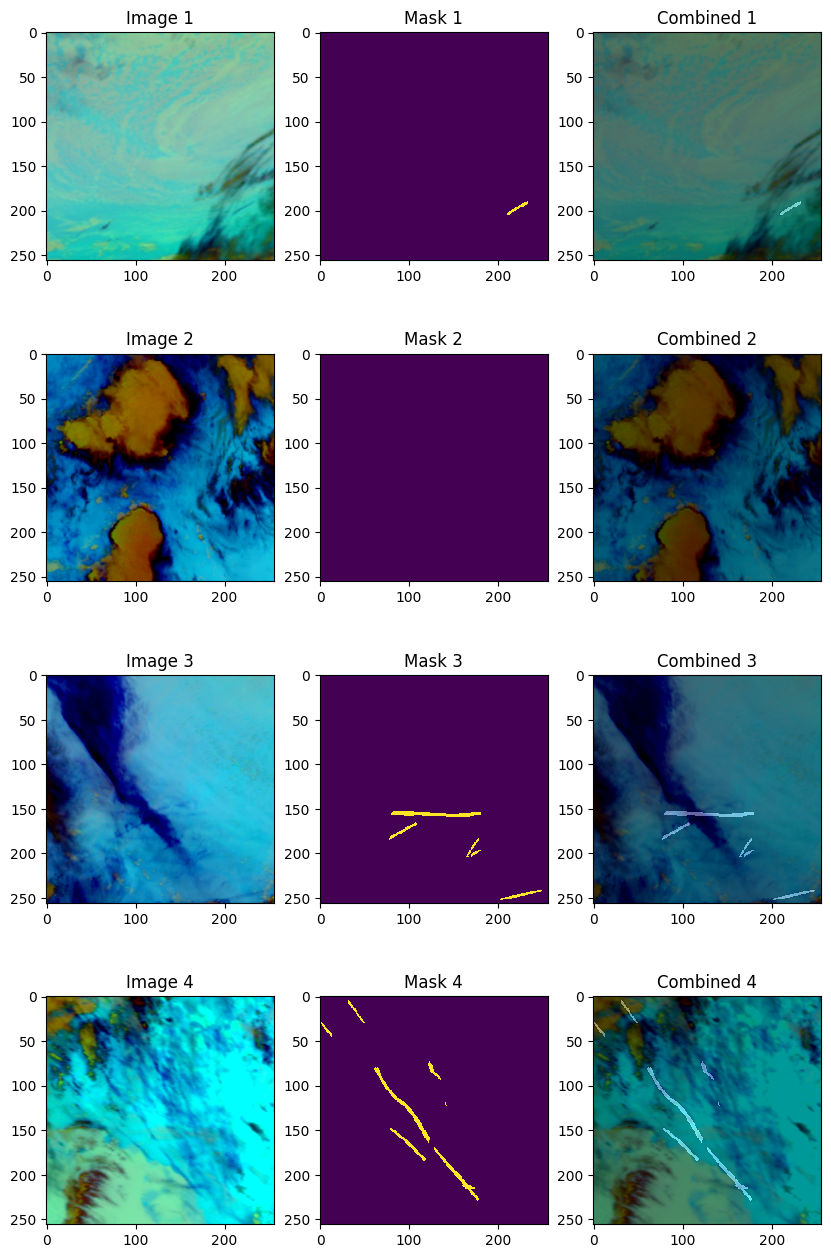

In [7]:
utils.plot_rgb_and_mask(image, mask)

In [8]:
img_grid = torchvision.utils.make_grid(image)
false_rgb = utils.get_rgb(img_grid)#
false_rgb.shape

torch.Size([3, 260, 1034])

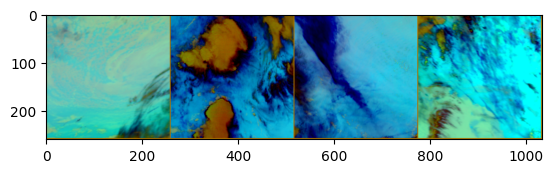

In [9]:
plt.imshow(false_rgb.cpu().numpy().transpose(1,2,0))

In [10]:
## Add to Tensorboard
## Pytorch 
writer = SummaryWriter('tensorboard/runs/BselineModel_Expr01')
# Write image data to TensorBoard log dir
writer.add_image('False RGB Images', false_rgb, 0) # First 3 bands image(swir, nir, red)
writer.flush()

## Model Building

In [11]:
baseline_model = BaseUnet(in_channels=9, out_channels=1)
model = baseline_model.to(DEVICE)

In [14]:
trainer_base = Trainer(
    model=model.to(DEVICE),
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    criterion=torch.nn.BCEWithLogitsLoss(),
    optimizer= torch.optim.Adamax(baseline_model.parameters(), lr=1e-4,),
    device=DEVICE, 
    tb_path = 'tensorboard/runs/BselineModel_Expr01', 
    checkpoint_path='test'
)

In [15]:
torch.cuda.empty_cache()
trainer_base.train(20)

Epoch 1/20: 100%|██████████| 371/371 [00:56<00:00,  6.52it/s]


Epoch 1/20, Training- Loss: 0.2063, Dice: 0.0889
Checkpoint saved at epoch 1
Validation- Loss: 0.1562 | IoU: 0.0426 | Dice: 0.0426
Checkpoint saved at epoch 1
Best model saved at epoch 1


Epoch 2/20: 100%|██████████| 371/371 [00:49<00:00,  7.46it/s]


Epoch 2/20, Training- Loss: 0.1285, Dice: 0.1024
Checkpoint saved at epoch 2
Validation- Loss: 0.0973 | IoU: 0.0213 | Dice: 0.0213
Checkpoint saved at epoch 2
Best model saved at epoch 2


Epoch 3/20: 100%|██████████| 371/371 [00:52<00:00,  7.08it/s]


Epoch 3/20, Training- Loss: 0.0819, Dice: 0.0916
Checkpoint saved at epoch 3
Validation- Loss: 0.0629 | IoU: 0.0213 | Dice: 0.0213
Checkpoint saved at epoch 3
Best model saved at epoch 3


Epoch 4/20: 100%|██████████| 371/371 [00:54<00:00,  6.83it/s]


Epoch 4/20, Training- Loss: 0.0562, Dice: 0.0836
Checkpoint saved at epoch 4
Validation- Loss: 0.0439 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 4
Best model saved at epoch 4


Epoch 5/20: 100%|██████████| 371/371 [00:53<00:00,  6.98it/s]


Epoch 5/20, Training- Loss: 0.0424, Dice: 0.1132
Checkpoint saved at epoch 5
Validation- Loss: 0.0329 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 5
Best model saved at epoch 5


Epoch 6/20: 100%|██████████| 371/371 [00:48<00:00,  7.60it/s]


Epoch 6/20, Training- Loss: 0.0350, Dice: 0.0943
Checkpoint saved at epoch 6
Validation- Loss: 0.0268 | IoU: 0.0426 | Dice: 0.0426
Checkpoint saved at epoch 6
Best model saved at epoch 6


Epoch 7/20: 100%|██████████| 371/371 [00:49<00:00,  7.57it/s]


Epoch 7/20, Training- Loss: 0.0313, Dice: 0.0863
Checkpoint saved at epoch 7
Validation- Loss: 0.0269 | IoU: 0.0213 | Dice: 0.0213
Checkpoint saved at epoch 7
Best model saved at epoch 7


Epoch 8/20: 100%|██████████| 371/371 [00:51<00:00,  7.19it/s]


Epoch 8/20, Training- Loss: 0.0291, Dice: 0.0970
Checkpoint saved at epoch 8
Validation- Loss: 0.0243 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 8
Best model saved at epoch 8


Epoch 9/20: 100%|██████████| 371/371 [00:55<00:00,  6.71it/s]


Epoch 9/20, Training- Loss: 0.0276, Dice: 0.0916
Checkpoint saved at epoch 9
Validation- Loss: 0.0223 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 9
Best model saved at epoch 9


Epoch 10/20: 100%|██████████| 371/371 [00:57<00:00,  6.40it/s]


Epoch 10/20, Training- Loss: 0.0269, Dice: 0.0863
Checkpoint saved at epoch 10
Validation- Loss: 0.0238 | IoU: 0.0638 | Dice: 0.0638
Checkpoint saved at epoch 10
Best model saved at epoch 10


Epoch 11/20: 100%|██████████| 371/371 [01:10<00:00,  5.30it/s]


Epoch 11/20, Training- Loss: 0.0262, Dice: 0.0970
Checkpoint saved at epoch 11
Validation- Loss: 0.0216 | IoU: 0.0213 | Dice: 0.0213
Checkpoint saved at epoch 11
Best model saved at epoch 11


Epoch 12/20: 100%|██████████| 371/371 [01:16<00:00,  4.86it/s]


Epoch 12/20, Training- Loss: 0.0253, Dice: 0.0997
Checkpoint saved at epoch 12
Validation- Loss: 0.0216 | IoU: 0.0426 | Dice: 0.0426
Checkpoint saved at epoch 12
Best model saved at epoch 12


Epoch 13/20: 100%|██████████| 371/371 [01:20<00:00,  4.60it/s]


Epoch 13/20, Training- Loss: 0.0252, Dice: 0.1159
Checkpoint saved at epoch 13
Validation- Loss: 0.0208 | IoU: 0.0213 | Dice: 0.0213
Checkpoint saved at epoch 13
Best model saved at epoch 13


Epoch 14/20: 100%|██████████| 371/371 [01:01<00:00,  6.05it/s]


Epoch 14/20, Training- Loss: 0.0245, Dice: 0.0943
Checkpoint saved at epoch 14
Validation- Loss: 0.0201 | IoU: 0.0213 | Dice: 0.0213
Checkpoint saved at epoch 14
Best model saved at epoch 14


Epoch 15/20: 100%|██████████| 371/371 [01:07<00:00,  5.46it/s]


Epoch 15/20, Training- Loss: 0.0241, Dice: 0.1078
Checkpoint saved at epoch 15
Validation- Loss: 0.0218 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 15
Best model saved at epoch 15


Epoch 16/20: 100%|██████████| 371/371 [01:00<00:00,  6.17it/s]


Epoch 16/20, Training- Loss: 0.0237, Dice: 0.0916
Checkpoint saved at epoch 16
Validation- Loss: 0.0250 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 16
Best model saved at epoch 16


Epoch 17/20: 100%|██████████| 371/371 [01:02<00:00,  5.96it/s]


Epoch 17/20, Training- Loss: 0.0235, Dice: 0.1024
Checkpoint saved at epoch 17
Validation- Loss: 0.0196 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 17
Best model saved at epoch 17


Epoch 18/20: 100%|██████████| 371/371 [00:58<00:00,  6.35it/s]


Epoch 18/20, Training- Loss: 0.0232, Dice: 0.0863
Checkpoint saved at epoch 18
Validation- Loss: 0.0185 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 18
Best model saved at epoch 18


Epoch 19/20: 100%|██████████| 371/371 [01:00<00:00,  6.14it/s]


Epoch 19/20, Training- Loss: 0.0228, Dice: 0.1132
Checkpoint saved at epoch 19
Validation- Loss: 0.0196 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 19
Best model saved at epoch 19


Epoch 20/20: 100%|██████████| 371/371 [01:01<00:00,  6.04it/s]


Epoch 20/20, Training- Loss: 0.0225, Dice: 0.1159
Checkpoint saved at epoch 20
Validation- Loss: 0.0180 | IoU: 0.0000 | Dice: 0.0000
Checkpoint saved at epoch 20
Best model saved at epoch 20
Finished Training


In [17]:
image.shape

torch.Size([4, 9, 256, 256])

In [20]:
data = image.to(DEVICE)

In [23]:
prediction = model(data)

In [29]:
plt.imshow(prediction[0][0].detach().numpy())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.